### **Preparation**
- install pyhealth alpha version

### **Step 1: Load dataset**
- **[README]:** We call [pyhealth.datasets](https://pyhealth.readthedocs.io/en/latest/api/datasets.html) to process and obtain the dataset. 
  - `root` is the arguments directing to the data folder. 
  - `tables` is a list of table names from raw databases, which specifies the information that will be used in building the pipeline. Currently, we provide [MIMIC3Dataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.MIMIC3Dataset.html), [MIMIC4Dataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.MIMIC4Dataset.html), [eICUDataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.eICUDataset.html), [OMOPDataset](https://pyhealth.readthedocs.io/en/latest/api/datasets/pyhealth.datasets.OMOPDataset.html).
  - `code_mapping [default: None]` asks a directionary input, specifying the new coding systems for each data table. For example, `{"NDC": ("ATC", {"target_kwargs": {"level": 3}})}` means that our pyhealth will automatically change the codings from `NDC` into ATC-3 level for tables if any.
  - `dev`: if set `True`, will only load a smaller set of patients.
- **[Next Step]:** This `pyhealth.datasets` object will be used in **Step 2**.
- **[Advanced Use Case]:** Researchers can use the dict-based output alone `dataset.patients` alone for supporting their own tasks.

In [1]:
from pyhealth.datasets import eICUDataset
print('Loading eICU dataset')
eicu_ds = eICUDataset(
    root='../../eicu_csv',
    tables=["treatment", "admissionDx", "diagnosisString"],
    refresh_cache=False,
    # dev=True
)

eicu_ds.stat()

Loading eICU dataset
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Parsing patients: 100%|██████████| 166355/166355 [01:48<00:00, 1539.95it/s]


finish basic patient information parsing : 110.53545117378235s
finish parsing treatment : 85.05459904670715s
finish parsing admissionDx : 40.46497368812561s
finish parsing diagnosisString : 87.52383041381836s


Mapping codes: 100%|██████████| 166355/166355 [00:03<00:00, 47449.01it/s]



Statistics of base dataset (dev=False):
	- Dataset: eICUDataset
	- Number of patients: 166355
	- Number of visits: 200859
	- Number of visits per patient: 1.2074
	- Number of events per visit in treatment: 18.3648
	- Number of events per visit in admissionDx: 3.1209
	- Number of events per visit in diagnosisString: 13.4954



'\nStatistics of base dataset (dev=False):\n\t- Dataset: eICUDataset\n\t- Number of patients: 166355\n\t- Number of visits: 200859\n\t- Number of visits per patient: 1.2074\n\t- Number of events per visit in treatment: 18.3648\n\t- Number of events per visit in admissionDx: 3.1209\n\t- Number of events per visit in diagnosisString: 13.4954\n'

In [2]:
# data format
eicu_ds.info()


dataset.patients: patient_id -> <Patient>

<Patient>
    - visits: visit_id -> <Visit> 
    - other patient-level info
    
    <Visit>
        - event_list_dict: table_name -> List[Event]
        - other visit-level info
    
        <Event>
            - code: str
            - other event-level info



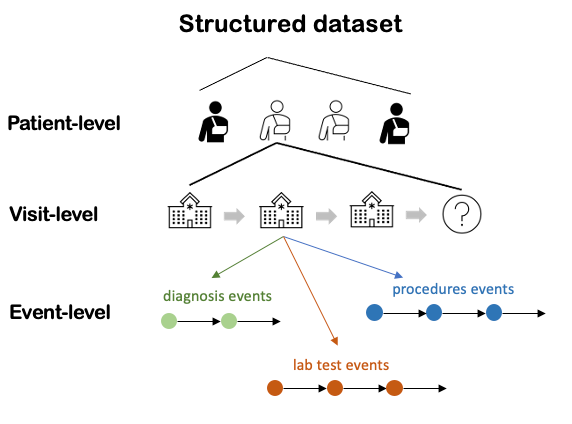

### **Step 2: Define healthcare task**
- **[README]:** This step assigns a **task function** to the dataset for data loading [pyhealth.tasks](https://pyhealth.readthedocs.io/en/latest/api/tasks.html). The **task function** specifics how to process each pateint's data into a set of samples for the downstream machine learning models. 
- **[Next Step]:** This `pyhealth.tasks` object will be used in **Step 3**.

In [4]:
from pyhealth.tasks import readmission_prediction_eicu_fn2

eicu_ds_readmission = eicu_ds.set_task(task_fn=readmission_prediction_eicu_fn2)
# stats info
eicu_ds_readmission.stat()

Generating samples for readmission_prediction_eicu_fn2: 100%|██████████| 166355/166355 [00:00<00:00, 307375.83it/s]


Statistics of sample dataset:
	- Dataset: eICUDataset
	- Task: readmission_prediction_eicu_fn2
	- Number of samples: 18568
	- Number of patients: 15965
	- Number of visits: 18568
	- Number of visits per patient: 1.1630
	- conditions:
		- Number of conditions per sample: 8.1288
		- Number of unique conditions: 3075
		- Distribution of conditions (Top-10): [('admission diagnosis|Was the patient admitted from the O.R. or went to the O.R. within 4 hours of admission?|No', 14958), ('admission diagnosis|Non-operative Organ Systems|Organ System|Cardiovascular', 6866), ('admission diagnosis|Was the patient admitted from the O.R. or went to the O.R. within 4 hours of admission?|Yes', 3610), ('pulmonary|respiratory failure|acute respiratory failure', 3517), ('admission diagnosis|Elective|Yes', 3234), ('admission diagnosis|Non-operative Organ Systems|Organ System|Respiratory', 3110), ('admission diagnosis|Non-operative Organ Systems|Organ System|Neurologic', 2187), ('renal|disorder of kidney|acut

"Statistics of sample dataset:\n\t- Dataset: eICUDataset\n\t- Task: readmission_prediction_eicu_fn2\n\t- Number of samples: 18568\n\t- Number of patients: 15965\n\t- Number of visits: 18568\n\t- Number of visits per patient: 1.1630\n\t- conditions:\n\t\t- Number of conditions per sample: 8.1288\n\t\t- Number of unique conditions: 3075\n\t\t- Distribution of conditions (Top-10): [('admission diagnosis|Was the patient admitted from the O.R. or went to the O.R. within 4 hours of admission?|No', 14958), ('admission diagnosis|Non-operative Organ Systems|Organ System|Cardiovascular', 6866), ('admission diagnosis|Was the patient admitted from the O.R. or went to the O.R. within 4 hours of admission?|Yes', 3610), ('pulmonary|respiratory failure|acute respiratory failure', 3517), ('admission diagnosis|Elective|Yes', 3234), ('admission diagnosis|Non-operative Organ Systems|Organ System|Respiratory', 3110), ('admission diagnosis|Non-operative Organ Systems|Organ System|Neurologic', 2187), ('renal

In [5]:
from pyhealth.datasets.splitter import split_by_patient
from pyhealth.datasets import split_by_patient, get_dataloader

# data split
train_dataset, val_dataset, test_dataset = split_by_patient(eicu_ds_readmission, [0.8, 0.1, 0.1])

# create dataloaders (they are <torch.data.DataLoader> object)
train_loader = get_dataloader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_dataloader(val_dataset, batch_size=64, shuffle=False)
test_loader = get_dataloader(test_dataset, batch_size=64, shuffle=False)

### **Step 3: Define ML Model**
- **[README]:** We initialize an ML model for the healthcare task by calling [pyhealth.models](https://pyhealth.readthedocs.io/en/latest/api/models.html).
- **[Next Step]:** This `pyhealth.models` object will be used in **Step 4**.
- **[Other Use Case]:** Our `pyhealth.models` object is as general as any instance from `torch.nn.Module`. Users may use it separately for supporting any other customized pipeline.

In [6]:
from pyhealth.models import Transformer

model = Transformer(
    dataset=eicu_ds_readmission,
    # look up what are available for "feature_keys" and "label_keys" in dataset.samples[0]
    feature_keys=["conditions", "procedures"],
    label_key="label",
    mode="binary",
)


### **Step 4: Model Training**
- **[README]:** We call our [pyhealth.train.Trainer](https://pyhealth.readthedocs.io/en/latest/api/trainer.html) to train the model by giving the `train_loader`, the `val_loader`, val_metric, and specify other arguemnts, such as epochs, optimizer, learning rate, etc. The trainer will automatically save the best model and output the path in the end.
- **[Next Step]:** The best model will be used in **Step 5** for evaluation.


In [7]:
from pyhealth.trainer import Trainer

trainer = Trainer(model=model)
trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    epochs=3,
    monitor="pr_auc",
)

Transformer(
  (embeddings): ModuleDict(
    (conditions): Embedding(3077, 128, padding_idx=0)
    (procedures): Embedding(2085, 128, padding_idx=0)
  )
  (linear_layers): ModuleDict()
  (transformer): ModuleDict(
    (conditions): TransformerLayer(
      (transformer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadedAttention(
            (linear_layers): ModuleList(
              (0): Linear(in_features=128, out_features=128, bias=False)
              (1): Linear(in_features=128, out_features=128, bias=False)
              (2): Linear(in_features=128, out_features=128, bias=False)
            )
            (output_linear): Linear(in_features=128, out_features=128, bias=False)
            (attention): Attention()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (feed_forward): PositionwiseFeedForward(
            (w_1): Linear(in_features=128, out_features=512, bias=True)
            (w_2): Linear(in_features=512, out_features=128

Epoch 0 / 3:   0%|          | 0/232 [00:00<?, ?it/s]

--- Train epoch-0, step-232 ---
loss: 0.5525
Evaluation: 100%|██████████| 29/29 [00:00<00:00, 264.74it/s]
--- Eval epoch-0, step-232 ---
pr_auc: 0.8713
roc_auc: 0.6311
f1: 0.8984
loss: 0.4571
New best pr_auc score (0.8713) at epoch-0, step-232



Epoch 1 / 3:   0%|          | 0/232 [00:00<?, ?it/s]

--- Train epoch-1, step-464 ---
loss: 0.4732
Evaluation: 100%|██████████| 29/29 [00:00<00:00, 250.05it/s]
--- Eval epoch-1, step-464 ---
pr_auc: 0.8781
roc_auc: 0.6423
f1: 0.9010
loss: 0.4545
New best pr_auc score (0.8781) at epoch-1, step-464



Epoch 2 / 3:   0%|          | 0/232 [00:00<?, ?it/s]

--- Train epoch-2, step-696 ---
loss: 0.4588
Evaluation: 100%|██████████| 29/29 [00:00<00:00, 212.30it/s]
--- Eval epoch-2, step-696 ---
pr_auc: 0.8797
roc_auc: 0.6368
f1: 0.9016
loss: 0.4595
New best pr_auc score (0.8797) at epoch-2, step-696
Loaded best model


### **Step 5: Evaluation**

In [8]:
# option 1: use our built-in evaluation metric
score = trainer.evaluate(test_loader)
print (score)

# option 2: use our pyhealth.metrics to evaluate
from pyhealth.metrics.binary import binary_metrics_fn
y_true, y_prob, loss = trainer.inference(test_loader)
binary_metrics_fn(y_true, y_prob, metrics=["pr_auc"])

Evaluation: 100%|██████████| 30/30 [00:00<00:00, 199.27it/s]


{'pr_auc': 0.8816371609872871, 'roc_auc': 0.6455070404677734, 'f1': 0.8966331955109275, 'loss': 0.4604034960269928}


Evaluation: 100%|██████████| 30/30 [00:00<00:00, 229.37it/s]


{'pr_auc': 0.8816371609872871}

If you find it useful, please give us a star ⭐ (fork, and watch) at https://github.com/sunlabuiuc/PyHealth. 

Thanks very much for your support!